In [6]:
import powerplantmatching as pm
from powerplantmatching.utils import (
    config_filter,
    convert_to_short_name,
    set_column_name,
)
from powerplantmatching.cleaning import clean_name
import pandas as pd

In [7]:
config = pm.get_config()
config["GNPT"]["status"] = ["operating", "construction", "pre-construction", "announced"]
config["target_columns"] += ["Status"]

In [8]:
df = pm.data.GNPT(raw=True)

In [9]:
RENAME_COLUMNS = {
    "Project Name": "Name",
    "Capacity (MW)": "Capacity",
    "Latitude": "lat",
    "Longitude": "lon",
    "Start Year": "DateIn",
    "Retirement Year": "DateOut",
    "Country/Area": "Country",
    "GEM unit ID": "projectID",
}

status_list = config["GNPT"]["status"]

df = df.rename(columns=RENAME_COLUMNS)
df = (
    df.pipe(clean_name)
    .pipe(set_column_name, "GNPT")
    .pipe(convert_to_short_name)
    .dropna(subset="Capacity")
    .assign(
        DateIn=df["DateIn"].apply(pd.to_numeric, errors="coerce"),
        DateOut=df["DateOut"].apply(pd.to_numeric, errors="coerce"),
        lat=df["lat"].apply(pd.to_numeric, errors="coerce"),
        lon=df["lon"].apply(pd.to_numeric, errors="coerce"),
    )
    .query("Status in @status_list")
    .pipe(lambda x: x[df.columns.intersection(config.get("target_columns"))])
    .assign(Fueltype="Nuclear")
    .assign(Technology="Steam Turbine")
    .assign(Set="PP")
    .pipe(config_filter, config)
    .query("Country != 'Ukraine'")
    .powerplant.convert_country_to_alpha2()
)

In [11]:
df.query("Country == 'SE'")

GNPT,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,DateIn,DateRetrofit,DateOut,lat,lon,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,EIC,projectID,Status
67,Forsmark,Nuclear,Steam Turbine,PP,SE,1078.0,NaN,1980.0,NaN,NaN,60.4028,18.17440,NaN,NaN,NaN,NaN,NaN,G100000500246,operating
68,Forsmark,Nuclear,Steam Turbine,PP,SE,1160.0,NaN,1981.0,NaN,NaN,60.4028,18.17440,NaN,NaN,NaN,NaN,NaN,G100000500146,operating
69,Forsmark,Nuclear,Steam Turbine,PP,SE,1208.0,NaN,1985.0,NaN,NaN,60.4028,18.17440,NaN,NaN,NaN,NaN,NaN,G100000500128,operating
138,Oskarshamn,Nuclear,Steam Turbine,PP,SE,1450.0,NaN,1985.0,NaN,NaN,57.4166,16.67301,NaN,NaN,NaN,NaN,NaN,G100000500041,operating
159,Ringhals,Nuclear,Steam Turbine,PP,SE,1117.0,NaN,1981.0,NaN,NaN,57.2574,12.10870,NaN,NaN,NaN,NaN,NaN,G100000500186,operating
160,Ringhals,Nuclear,Steam Turbine,PP,SE,1171.0,NaN,1983.0,NaN,NaN,57.2574,12.10870,NaN,NaN,NaN,NaN,NaN,G100000500129,operating


In [6]:
rebuild_i = df.query("DateIn <= 1990 or DateOut <= 2045 or Status == 'announced'").index
df.loc[rebuild_i, "Capacity"] = 0.
df.loc[rebuild_i, "DateIn"] = 2045
#df.drop("Status", axis=1, inplace=True, errors="ignore")
df.fillna({"DateIn": 2045}, inplace=True)
df

GNPT,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,DateIn,DateRetrofit,DateOut,lat,lon,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,EIC,projectID,Status
0,Almaraz,Nuclear,Steam Turbine,PP,ES,0.0,NaN,2045.0,NaN,NaN,39.807000,-5.698600,NaN,NaN,NaN,NaN,NaN,G100000500240,operating
1,Almaraz,Nuclear,Steam Turbine,PP,ES,0.0,NaN,2045.0,NaN,NaN,39.807000,-5.698600,NaN,NaN,NaN,NaN,NaN,G100000500239,operating
2,Asco,Nuclear,Steam Turbine,PP,ES,0.0,NaN,2045.0,NaN,NaN,41.199300,0.569400,NaN,NaN,NaN,NaN,NaN,G100000500243,operating
3,Asco,Nuclear,Steam Turbine,PP,ES,0.0,NaN,2045.0,NaN,NaN,41.199300,0.569400,NaN,NaN,NaN,NaN,NaN,G100000500242,operating
4,Belleville,Nuclear,Steam Turbine,PP,FR,0.0,NaN,2045.0,NaN,NaN,47.510300,2.875010,NaN,NaN,NaN,NaN,NaN,G100000500060,operating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Vandellos,Nuclear,Steam Turbine,PP,ES,0.0,NaN,2045.0,NaN,NaN,40.951100,0.866200,NaN,NaN,NaN,NaN,NaN,G100000500241,operating
195,Wloclawek,Nuclear,Steam Turbine,PP,PL,0.0,NaN,2045.0,NaN,NaN,52.671809,19.053763,NaN,NaN,NaN,NaN,NaN,G100001009068,announced
196,Wloclawek,Nuclear,Steam Turbine,PP,PL,0.0,NaN,2045.0,NaN,NaN,52.671809,19.053763,NaN,NaN,NaN,NaN,NaN,G100001009066,announced
197,Wloclawek,Nuclear,Steam Turbine,PP,PL,0.0,NaN,2045.0,NaN,NaN,52.671809,19.053763,NaN,NaN,NaN,NaN,NaN,G100001009067,announced


In [7]:
df.to_csv("../pypsa-eur/data/custom_powerplants.csv")

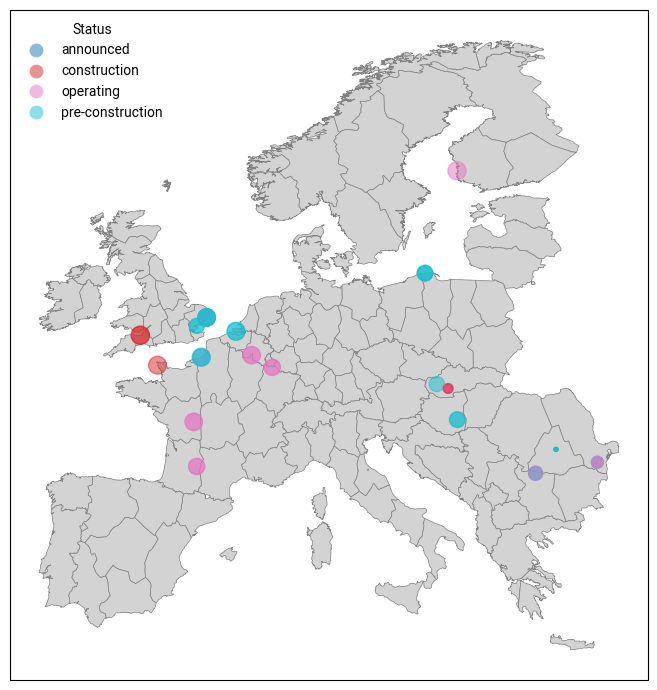

In [11]:
import geopandas as gpd

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

regions_fn = "../pypsa-eur/resources/20240826-z1/regions_onshore_base_s_115.geojson"
regions = gpd.read_file(regions_fn).set_index("name")

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326",
)

crs = ccrs.EqualEarth()
fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': crs})
regions.to_crs(crs.proj4_init).plot(ax=ax, color="lightgrey", edgecolor="grey", linewidth=0.5)
gdf.to_crs(crs.proj4_init).plot(ax=ax, column=gdf.Status, cmap="tab10", markersize=gdf.Capacity / 10, alpha=0.5, legend=True, legend_kwds={"title": "Status", "loc": "upper left"})

plt.tight_layout()

plt.savefig("nuclear.pdf")


52209.0